**Project - Advanced Search Engine and Recommendation System for an e-commerce product recommendation**

#### Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gensim --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 81.5 MB/s eta 0:00:00


In [ ]:
# DATA MANIPULATION
import pandas as pd
import numpy as np

# VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# NLP-TEXT MINING
import nltk
import scipy
import re
from scipy import spatial
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
tokenizer = ToktokTokenizer()

# OTHER LIBRARIES
import gensim
from gensim.models import Word2Vec
import itertools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import linear_kernel

import warnings
warnings.filterwarnings(action='ignore')

#### Data understanding

We use a kaggle dataset of an e-commerce website that contains 20,002 observations and 15 attributes. Attributes include information such as the product name, description, retail price, discounted price, product
rating, overall rating, brand, product specifications, etc.

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP-Projects/flipkart_com-ecommerce_sample.csv'
data = pd.read_csv(file_path)

data.shape

(20002, 15)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20002 entries, 0 to 20001
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  20000 non-null  object 
 1   crawl_timestamp          20000 non-null  object 
 2   product_url              20000 non-null  object 
 3   product_name             20000 non-null  object 
 4   product_category_tree    20000 non-null  object 
 5   pid                      20000 non-null  object 
 6   retail_price             19922 non-null  float64
 7   discounted_price         19922 non-null  float64
 8   image                    19997 non-null  object 
 9   is_FK_Advantage_product  20000 non-null  object 
 10  description              19998 non-null  object 
 11  product_rating           20000 non-null  object 
 12  overall_rating           20000 non-null  object 
 13  brand                    14136 non-null  object 
 14  product_specifications

Here we add, to the DataFrame, two additional features: description length (number of characters) and word count (number of words before preprocessing). The word counts were then grouped into bins, and a bar plot was generated using Seaborn to visualize the distribution across these bins.

Text(0.5, 1.0, 'Word distribution per bin')

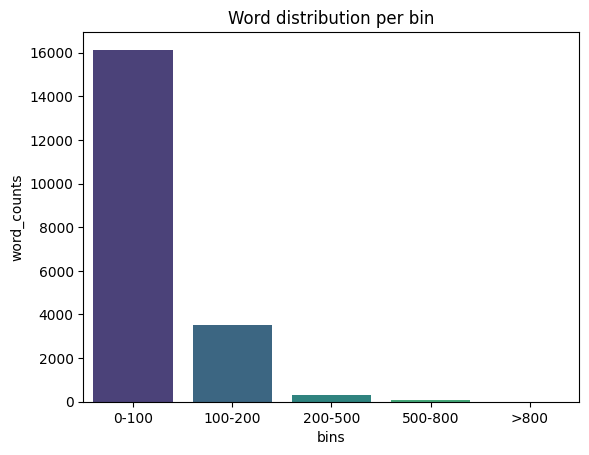

In [ ]:
# Add a new column :length of the description
data['length'] = data['description'].str.len()

# Add a new column : number of words in the description before text preprocessing
data['no_of_words'] = data['description'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)

# Word count distribution for description
bins = [0, 50, 75, np.inf]
data['bins' ] = pd.cut(data.no_of_words, bins=[0, 100, 300, 500, 800, np.inf],
                       labels=['0-100', '100-200', '200-500', '500-800','>800'])

words_distribution = data.groupby('bins').size().reset_index().rename(columns={0: 'word_counts'})
sns.barplot(x='bins', y='word_counts', data=words_distribution, palette='viridis').set_title("Word distribution per bin")

#### Data Pre-processing

Data preprocessing began with data cleaning by identifying missing values using isnull() and computing their counts and percentages per column. A summary DataFrame was created to highlight columns with significant missing data, helping assess their impact and guide subsequent handling strategies.

In [ ]:
# Number of missing values in each column
missing = pd.DataFrame(data.isnull().sum()).rename (columns = {0:'missing'})

# Create a percentage of missing values
missing['percent'] = missing [ 'missing']/len(data)

# Sorting the values in desending order to see highest count on the top
missing.sort_values('percent', ascending=False)

,missing,percent
brand,5866,0.293271
discounted_price,80,0.004000
retail_price,80,0.004000
product_specifications,16,0.000800
image,5,0.000250
length,4,0.000200
description,4,0.000200
bins,4,0.000200
crawl_timestamp,2,0.000100
uniq_id,2,0.000100


#### Text Pre-processing

In [ ]:
# Remove punctuation
data['description'] = data['description'].str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)

# Replace whitespace between terms with a single space
data['description'] = data['description'].str.replace(r"\s+", " ", regex=True)

# converting to lower case
data['description'] = data['description'].str.lower()

# Remove leading and trailing whitespace
data['description'] = data['description'].str.strip()

data['description'].head()

,description
0,key features of alisha solid women s cycling s...
1,fabhomedecor fabric double sofa bed finish col...
2,key features of aw bellies sandals wedges heel...
3,key features of alisha solid women s cycling s...
4,specifications of sicons all purpose arnica do...


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

data['description'] = data['description'].fillna("").astype(str)

# Remove stopwords
data['description'] = data['description'].apply(lambda x: " ".join([w for w in x.split() if w not in stop]))

# Removing single caharacters
data['description'] = data['description'].apply(lambda x: " ".join(w for w in x.split() if len(w) > 1))

# Removing domain related stop words from description
specific_stop_words= [ "rs", "flipkart", "buy", "com", "free", "day", "cash", "replacement", "guarantee", "genuine", "key", "feature", "delivery", "products", "product", "shipping", "online", "india", "shop"]
data['description'] = data['description'].apply(lambda x: " ".join(x for x in x.split() if x not in specific_stop_words))

data['description'] = data['description'].str.replace(r"\s+", " ", regex=True).str.strip()

data['description'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,description
0,features alisha solid women cycling shorts cot...
1,fabhomedecor fabric double sofa bed finish col...
2,features aw bellies sandals wedges heel casual...
3,features alisha solid women cycling shorts cot...
4,specifications sicons purpose arnica dog shamp...


The text processing phase involved a series of steps, including lowercase conversion, stopwords
removal, elimination of single characters, and analysis of word frequency. These steps collectively contribute
to cleaning and refining the text data, facilitating upcoming tasks. We also examine the most frequent words in the corpus after removing domain-specific stopwords. By doing so, we can identify common terms that hold significance in the dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[('women', 10574), ('30', 7830), ('features', 7199), ('price', 6705), ('shirt', 5796), ('color', 5743), ('type', 5377), ('details', 5300), ('specifications', 5155), ('men', 5033)]


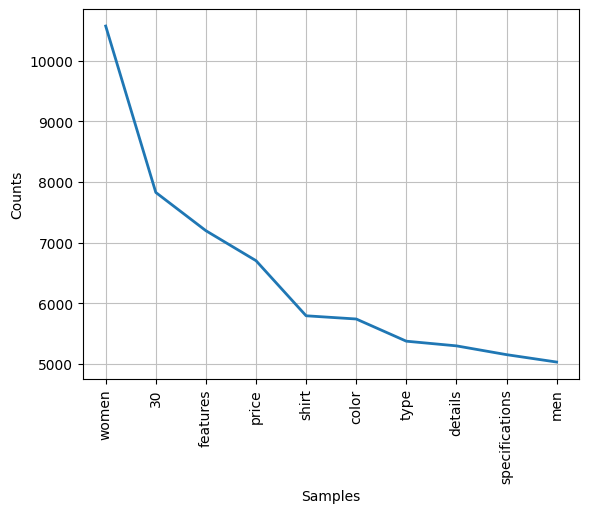

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Top frequent words after removing domain related stop words
a = data['description'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)
word_dist.plot(10, cumulative=False)
print(word_dist.most_common(10))

#### Model Building

##### Content-Based Recommendation System

1. Clean and Vectorize Text
2. Reverse Mapping: Create a reverse mapping of indices to product names using the product_name
column
3. Define the *predict_products* Function: This function takes a product title as input and returns
the most similar products
4. Compute Similarity Scores
5. Sort and Return Recommendations

In [ ]:
# text cleaning
data['description'] = data['description'].fillna('')

# define the vectorizer
T_vec = TfidfVectorizer(stop_words='english')

# get the vectors
T_vec_matrix = T_vec.fit_transform(data['description'])

# shape
T_vec_matrix.shape

(20002, 26015)

In [ ]:
# Reversing the map of indices and product
product_index = pd.Series(data.index, index=data['product_name']).drop_duplicates()
product_index

,0
product_name,
Alisha Solid Women's Cycling Shorts,0
FabHomeDecor Fabric Double Sofa Bed,1
AW Bellies,2
Alisha Solid Women's Cycling Shorts,3
Sicons All Purpose Arnica Dog Shampoo,4
...,...
Elite Collection Medium Acrylic Sticker,19997
Elite Collection Medium Acrylic Sticker,19998
Elite Collection Medium Acrylic Sticker,19999


In [ ]:
def predict_products(text):
    # Check if the product name is present in the index dictionary
    if text.strip() in product_index:
        # Get the index of the product
        index = product_index[text.strip()]
        # Obtain the pairwise similarity scores
        score_matrix = linear_kernel(T_vec_matrix[index], T_vec_matrix)
        matching_sc = list(enumerate(score_matrix[0]))
        # Sort the products based on the similarity scores
        matching_sc = sorted(matching_sc, key=lambda x: x[1], reverse=True)
        # Getting the scores of the 10 most similar products
        matching_sc = matching_sc[1:10]
        # Getting the product indices
        product_indices = [i[0] for i in matching_sc]
        # Show the similar products
        return data['product_name'].iloc[product_indices]
    else:
        return None

# Prompt the user for a product name and get the recommended products
product_name = input("Enter a product name: ")
recommended_products = predict_products(product_name)

if recommended_products is not None:
    print("Similar products:")
    print("\n".join(recommended_products))
else:
    print("Product not found in the dataset.")

Enter a product name: Alisha Solid Women's Cycling Shorts
Similar products:
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Alisha Solid Women's Cycling Shorts
Mynte Solid Women's Cycling Shorts, Gym Shorts, Swim Shorts
Mynte Solid Women's Cycling Shorts, Gym Shorts, Swim Shorts
Mynte Solid Women's Cycling Shorts, Gym Shorts, Swim Shorts


##### Search Engine

###### Product Search Engine

1. Creation of Product Descriptions List: Iterate over the dataset’s description column to create a list of
product descriptions.

2. Create a new DataFrame that includes only the relevant columns needed for the search engine.

3. Load a pre-trained Word2Vec model, which generates word
embeddings. These embeddings capture the semantic meaning and relationships between words.

4. Preprocessing and Ranking Functions: Preprocessing functions to remove stopwords and perform any necessary text cleaning. Ranking functions, such as cosine similarity, to measure the similarity between user queries and product descriptions.

5. Search Function.

In [ ]:
# Creating list containing description of each product as sublist
data['description'] = data['description'].fillna("").astype(str)

fin = [ ]
for i in range(len(data['description'])):
  temp = []
  temp.append(data['description'][i])
  fin = fin + temp

data1 = data[['product_name', 'description']]

In [ ]:
# import the word2vec
from gensim.models import KeyedVectors
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Preprocessing
def remove_stopwords(text, is_lower_case=False):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Obtain the embeddings, lets use “300”
def get_embedding(word) :
 if word in model.key_to_index:
  return model[word]
 else:
  return np.zeros(300)

# Obtaining the average vector for all the documents
out_dict = {}
for sen in fin:
  processed_text = remove_stopwords(sen)
  tokens = nltk.word_tokenize(processed_text)

  if len(tokens) == 0:
    average_vector = np.zeros(300)
  else:
    average_vector = np.mean(np.array([get_embedding(x) for x in tokens]), axis=0)

  out_dict[sen] = average_vector

# Get the similarity between the query and documents
def get_sim(query_embedding, doc_embedding):
  return 1 - scipy.spatial.distance.cosine(query_embedding, doc_embedding)

# Rank all the documents based on the similarity
def Ranked_documents(query):
    query_words = np.mean(
        np.array([get_embedding(x) for x in nltk.word_tokenize(remove_stopwords(query.lower()))], dtype=float),
        axis=0
    )
    rank = []
    for k, v in out_dict.items():
        score = get_sim(query_words, v)
        if score < 1:
            rank.append((k, score))
    rank = sorted(rank, key=lambda t: t[1], reverse=True)
    ranked_rows = []
    for desc, score in rank:
        row = data1[data1['description'] == desc].copy()
        row['score'] = score
        ranked_rows.append(row)
    ranked_df = pd.concat(ranked_rows, ignore_index=True)
    ranked_df = ranked_df.sort_values(by='score', ascending=False)
    print('Ranked Documents:')
    return ranked_df[['product_name', 'description', 'score']]

In [ ]:
# Call the IR function with a query
query = input("What would you like to search: ")
Ranked_documents(query)

What would you like to search: dress
Ranked Documents:


,product_name,description,score
0,Mykraft Girl's A-line Dress,mykraft girl line dress price 964 blue lace st...,0.812852
1,ABHIRA Girl's A-line Dress,abhira girl line dress price 699 give trendy b...,0.799850
2,ABHIRA Girl's A-line Dress,abhira girl line dress price 499 give trendy b...,0.786744
3,Meish Women's Sheath Dress,meish women sheath dress price 764 bring diva ...,0.778662
4,Cutecumber Girl's A-line Dress,cutecumber girl line dress price 995 printed d...,0.768980
...,...,...,...
19966,Setu Infocom 4 Port Fxo Gateway,setu infocom port fxo gateway 18000 30,-0.021837
19967,Digisol DG-BG4100N,digisol dg bg4100n 1470 30,-0.023152
19968,Rega IT Compaq Presario V3500 V3500CTO 6 Cell ...,rega compaq presario v3500 v3500cto cell cell ...,-0.023499
19969,Retina Steering Mobile Holder,retina steering mobile holder 145 30,-0.037296


###### Advanced Search Engine Using PyTerrier and Sentence-BERT

1. Importing Libraries: nltk, pyterrier, sentence-transformers, and neuspell are imported.

2. Loading Pre-trained SentenceTransformer Model.

3. Reading and Preprocessing Data: Read the dataset, Perform preprocessing steps are performed on the df DataFrame to obtain a modified DataFrame called uniq_prod. These steps include splitting and cleaning the product_category_tree column, dropping unwanted columns, applying keyword filtering, combining keywords, and creating additional columns.

4. Building the Advanced Search Engine: The advanced search engine is built using PyTerrier. First,
an index is created for product keywords using TF-IDF weighting. Then, the search query and product
descriptions are encoded using Sentence-BERT to obtain semantic embeddings. Cosine similarity scores
are calculated between the query and product embeddings, and the results are sorted based on similarity.
The top 10 products with the highest similarity scores are displayed as recommendations.


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import re

import nltk
nltk.download('punkt' )
nltk.download('wordnet' )
nltk.download('stopwords' )
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english' ))
exclude = set(string.punctuation)
import string

!pip install python-terrier
import pyterrier as pt
if not pt.started():
 pt.init()
!pip install -U sentence-transformers

!pip install neuspell
!pip install -e neuspell/
!git clone https://github.com/neuspell/neuspell; cd neuspell
import os
os.chdir("/content/neuspell" )

!pip install -r /content/neuspell/extras-requirements.txt
!python -m spacy download en_core_web_sm

#Unzipping the multi-linguistic packages
#!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
#!unzip *.zip

# importing neuspell
from neuspell import BertChecker
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.8 MB/s eta 0:00:00
terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-assemblies/5.11/terrier-assemblies-5.11-jar-with-dependenci…

Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...


https://repo1.maven.org/maven2/org/terrier/terrier-python-helper/0.0.8/terrier-python-helper-0.0.8.jar:   0%| …

Done


Java started and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
/tmp/ipython-input-2066929265.py:23: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00
ERROR: neuspell/ is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
Cloning into 'neuspell'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (7/7), done.
remote: Tota

**Loading Pre-trained SentenceTransformer Model**

In [ ]:
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

file_path = '/content/drive/MyDrive/Colab Notebooks/NLP-Projects/flipkart_com-ecommerce_sample.csv'
df = pd.read_csv(file_path)

df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


**Reading and Preprocessing Data**

In [ ]:
df['product_category_tree'] = df['product_category_tree'].fillna("").astype(str)

# make the 'category_tree' column a simple list
df['product_category_tree'] = df['product_category_tree'].fillna('').astype(str).map(lambda x:x.strip('[]'))
df['product_category_tree'] = df['product_category_tree'].map(lambda x:x.strip('"'))
df['product_category_tree'] = df['product_category_tree'].map(lambda x:x.split('>>'))

# drop unwanted columns
df.drop(["crawl_timestamp", "product_url", "image", "retail_price", "discounted_price", "is_FK_Advantage_product",
         "product_rating", "overall_rating", "product_specifications"], axis=1, inplace=True)

# drop duplicate products
uniq_prod = df.copy()
uniq_prod.drop_duplicates(subset="product_name", keep = "first", inplace =True)

# Remove stop words and punctuations and then perform tokenization and lemmatization
def filter_keywords(doc):
 doc = doc. lower( )
 stop_free = " ".join([i for i in doc.split() if i not in stop_words])
 punc_free = "".join(ch for ch in stop_free if ch not in exclude)
 word_tokens = word_tokenize(punc_free)
 filtered_sentence = [(lem.lemmatize(w, "v")) for w in word_tokens]
 return filtered_sentence

for col in ['product_name', 'description', 'brand']:
    uniq_prod[col] = uniq_prod[col].fillna("").astype(str)

# Apply the filter_keywords function to selected columns to obtain the keywords for each column
uniq_prod['product'] = uniq_prod['product_name'].apply(filter_keywords)
uniq_prod['description'] = uniq_prod['description'].astype("str").apply(filter_keywords)
uniq_prod['brand'] = uniq_prod['brand'].astype("str").apply(filter_keywords )

# Combine all the keywords for each product
uniq_prod["keywords"] = uniq_prod['product'] + uniq_prod['brand'] + df['product_category_tree'] + uniq_prod['description']
uniq_prod["keywords"] = uniq_prod["keywords"].apply(lambda x: ' '.join(x))

# Creating a'docno' column, which gives recommendations
uniq_prod['docno' ] = uniq_prod['product_name']

# Drop unwanted columns
uniq_prod.drop(['product', 'brand', 'pid', 'product_name'], axis=1, inplace=True)

uniq_prod.head()

,uniq_id,product_category_tree,description,keywords,docno
0,c2d766ca982eca8304150849735ffef9,"[Clothing , Women's Clothing , Lingerie, Sle...","[key, feature, alisha, solid, womens, cycle, s...",alisha solid womens cycle short alisha Clothin...,Alisha Solid Women's Cycling Shorts
1,7f7036a6d550aaa89d34c77bd39a5e48,"[Furniture , Living Room Furniture , Sofa Be...","[fabhomedecor, fabric, double, sofa, bed, fini...",fabhomedecor fabric double sofa bed fabhomedec...,FabHomeDecor Fabric Double Sofa Bed
2,f449ec65dcbc041b6ae5e6a32717d01b,"[Footwear , Women's Footwear , Ballerinas , ...","[key, feature, aw, belly, sandals, wedge, heel...",aw belly aw Footwear Women's Footwear Ball...,AW Bellies
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,"[Pet Supplies , Grooming , Skin & Coat Care ...","[specifications, sicons, purpose, arnica, dog,...",sicons purpose arnica dog shampoo sicons Pet S...,Sicons All Purpose Arnica Dog Shampoo
5,c2a17313954882c1dba461863e98adf2,[Eternal Gandhi Super Series Crystal Paper Wei...,"[key, feature, eternal, gandhi, super, series,...",eternal gandhi super series crystal paper weig...,Eternal Gandhi Super Series Crystal Paper Weig...


**Building the Search Engine**

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
from neuspell import BertChecker

# use the DFIndexer object to create the index for keywords
!rm -rf /content/pd_index
!rm -rf /content/iter_index_porter
pd_indexer = pt.DFIndexer("/content/pd_index")
indexref = pd_indexer.index(uniq_prod["keywords"], uniq_prod["docno"])

# implementing the NeuSpell spell checker on the user query and save it to an object
# spellcheck= BertChecker()
# spellcheck.from_pretrained('bert-base-uncased')
# spellcheck.from_pretrained(ckpt_path=f"/content/multi_cased_L-12_H-768" )
# spellcheck.from_pretrained(ckpt_path='bertscrnn-probwordnoise')
# "<folder where the model is saved>"

X = input("Search Engine:")
query = X
print(query)

# Perform ranking and retrieval using PyTerrier and Sentence-BERT
prod_ret = pt.BatchRetrieve(indexref, wmodel='TF_IDF', properties={'termpipelines': 'Stopwords'})
pr = prod_ret.compile()
output = pr.search(query)
docno = list(output['docno'])
transform = model.encode(docno)

# Create embeddings and re-ranking using PyTerrier and cosine similarity
embedding = { }
for i, product in enumerate(docno):
  embedding[product] = transform[i]
q_embedding = model.encode(query).reshape(1, -1)
l = []
for product in embedding.keys():
  score = cosine_similarity(q_embedding, embedding[product].reshape(1,-1))[0][0]
  l.append([product, score])
  output2 = pd.DataFrame(l,columns=['product_name','score'])

output2.sort_values(by='score', ascending=False).head(10)

14:48:52.960 [main] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index () - further warnings are suppressed
14:48:53.982 [main] WARN org.terrier.structures.indexing.Indexer -- Indexed 1 empty documents
Search Engine:AW Bellies
AW Bellies


,product_name,score
0,AW Bellies,1.000000
25,Oggo Deo Bellies,0.874237
30,Treppe Bellies,0.861926
6,Ladela Bellies,0.858016
34,Kanvas Bellies,0.840706
20,BrandTrendz Bellies,0.837392
23,SCANTIA Bellies,0.829229
14,Bonzer Bellies,0.823341
16,Footash Bellies,0.783452
12,Mobiroy Bellies,0.751998


###### Multilingual Search Engine Using Deep Text Search

1. Installing Dependencies

2. Spell Checking and Query Expansion: The BertChecker class is utilized for spell checking in this step. Relevant words from the input query are extracted using POS tagging, and the query is expanded by adding synonyms obtained from WordNet. This helps improve the accuracy and coverage of the search
engine.

3. Dataset Loading and Embedding: The dataset is loaded, and a dictionary is created to map product descriptions to their names. The dataset is then embedded and stored for efficient searching. This involves encoding the text data into numerical representations to capture the semantic meaning of the content.

4. Performing Search: The expanded query is used to search the dataset for relevant products. The TextSearch class from the DeepTextSearch library is employed to find the top 10 most similar results based on the provided query. The product names, obtained from the created dictionary, are displayed as
the search results.

5. Multilingual Capability: With the implemented steps, the search engine can understand and process search queries in different languages. It is able to accurately retrieve relevant results, regardless of the
language used by the user.

In [ ]:
!pip install DeepTextSearch

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger' )
nltk.download('maxent_ne_chunker' )
nltk.download( 'words' )
nltk.download( 'wordnet' )

from DeepTextSearch import TextEmbedder, TextSearch, LoadData
from nltk.corpus import wordnet
from neuspell import BertChecker

  Preparing metadata (setup.py) ... done
  Created wheel for DeepTextSearch: filename=DeepTextSearch-0.3-py3-none-any.whl size=5962 sha256=558a63695fc80052066699989a4561724694ab1875900b7c47fc5055bf8b2fe7
  Stored in directory: /root/.cache/pip/wheels/36/18/4a/b960a3c578f5454ddb20d5687ce9a96a67a96e028aa05915ed
Successfully built DeepTextSearch


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Spell Checking and Query Expansion**

In [ ]:
# use BERTChecker for spell checking. It also supports multiple languages.
#spellcheck = BertChecker()
#spellcheck.from_pretrained(ckpt_path=f"/content/multi_cased_L-12_H-768_A12")
# "<folder where the model is saved>"

# input the query and check how its works
X = input("Enter Product Name:")
y = X
print(y)

# Download the specific NLTK resource for English POS tagging
nltk.download('averaged_perceptron_tagger_eng')

# Use POS tagging to select relevant words from the given query
# function to get the POS tag
def preprocess(sent):
  sent = nltk.word_tokenize(sent)
  sent = nltk.pos_tag(sent)
  return sent
sent = preprocess(y)
l = []
for i in sent:
  if i[1]=='NNS' or i[1]=='NN':
    l.append(i[0])
print(l)

# Use query expansion to get synonyms of words, so that we can get more relevant recommendations
query = ""

for i in l:
  query += i
  synset = wordnet.synsets(i)
  query += "_"+synset[0].lemmas()[0].name() + " "
print(query)

# Created this dictionary to display the product names as per the recommendations given in the description
# importing the data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP-Projects/flipkart_com-ecommerce_sample.csv')
df1 = df.set_index("description", inplace=False)
df2 = df1.to_dict()
dict1 = df2['product_name']

# Embed the data in a pickle file as the library requires it to be in that format
data = LoadData().from_csv('/content/drive/MyDrive/Colab Notebooks/NLP-Projects/flipkart_com-ecommerce_sample.csv')
TextEmbedder().embed(corpus_list=data)
corpus_embedding = TextEmbedder().load_embedding()

# Search the ten most relevant products based on the query
n = 10
t = TextSearch().find_similar(query_text=query,top_n=n)
for i in range(n):
  t[i]['text'] = dict1[t[i]['text']]
  print(t[i])

Enter Product Name:AW Bellies
AW Bellies
['Bellies']


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Bellies_abdomen 
Input the text Column Name Please ? : description


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Embedding data Saved Successfully!
['corpus_embeddings_data.pickle', 'corpus_list_data.pickle']
Embedding data Loaded Successfully!
['corpus_embeddings_data.pickle', 'corpus_list_data.pickle']
{'index': 532, 'text': 'Bonzer Bellies', 'score': np.float32(0.37488148)}
{'index': 17660, 'text': 'tryfeet Open Toe Blue Bellies', 'score': np.float32(0.363269)}
{'index': 15950, 'text': 'Bow! Wow!! ROUNDREDLALBIG L Pet Bed', 'score': np.float32(0.3609818)}
{'index': 10513, 'text': 'My Look KBSB-05-Beige-41 Bellies', 'score': np.float32(0.35765353)}
{'index': 16952, 'text': 'Bajya Cotton Bath Towel', 'score': np.float32(0.35402027)}
{'index': 10, 'text': 'Ladela Bellies', 'score': np.float32(0.35267887)}
{'index': 3378, 'text': 'Footash Bellies', 'score': np.float32(0.35087898)}
{'index': 3020, 'text': 'Bootwale Bellies', 'score': np.float32(0.35072368)}
{'index': 15870, 'text': 'Bow! Wow!! ROUNDBEDLALREDMED M Pet Bed', 'score': np.float32(0.350032)}
{'index': 3065, 'text': 'Bootwale Bellies', '

**Dataset Loading and Embedding**

In [ ]:
from DeepTextSearch import LoadData

data1 = LoadData().from_csv('/content/drive/MyDrive/Colab Notebooks/NLP-Projects/flipkart_com-ecommerce_sample.csv')

TextEmbedder().embed(corpus_list=data1)
corpus_embedding = TextEmbedder().load_embedding()

Input the text Column Name Please ? : description
Embedding data allready present, Do you want Embed & Save Again? Enter yes or no
yes


Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Embedding data Saved Successfully Again!
['corpus_embeddings_data.pickle', 'corpus_list_data.pickle']
Embedding data Loaded Successfully!
['corpus_embeddings_data.pickle', 'corpus_list_data.pickle']


**Performing Search and Multilingual Capability**

In [ ]:
y1 = input("Search Engine:")
TextSearch().find_similar(query_text=y1, top_n=10)

Search Engine:chapeau


[{'index': 16131,
  'text': 'Saviour HPSAVTHRW Saviour Tough Hat With Ratchet -White Fire Fighting Helmet (Size - M)\n                         Price: Rs. 180\n\t\t\t\t\n\t\t\tSaviour Tough Hat Industrial Helmet made of high impact, Heat and Chemical resistant HDPE polymer with 6-point adjustable and comfortable Head harness in ratchet fittings with high absorption and washable Sweatband. Comes with high tensile Nylon Chin strap with special structure brim design.\nSaviour Tough Hat Industrial Helmet made of high impact, Heat and Chemical resistant HDPE polymer with 6-point adjustable and comfortable Head harness in ratchet fittings with high absorption and washable Sweatband. Comes with high tensile Nylon Chin strap with special structure brim design.',
  'score': np.float32(0.381582)},
 {'index': 15904,
  'text': 'Saviour HPSAVTHRB Tough Hat with Ratchet -Blue Fire Fighting Helmet (Size - M)\n                         Price: Rs. 180\n\t\t\t\t\n\t\t\tSaviour Tough Hat Industrial Helmet 